GOOG & AAPL

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [93]:
class TradingStrategyAnalyzer:
    def __init__(self):
        pass

    def performance(self, x, ntrades=1, cost=0):
        """
        Calculates the performance of a stock or portfolio given the returns data.
        
        Parameters:
        x (pd.Series): an array containing the daily returns of the stock or portfolio.
        ntrades (int, optional): the number of trades. Default is 1.
        cost (float, optional): the transaction cost for each trade. Default is 0.
        
        Returns:
        Series: A pandas Series object containing the performance statistics of the stock or portfolio. 
        The Series object has the following indices:
            - Cumulative Return
            - Annual Return
            - Annualized Sharpe Ratio
            - Win %
            - Annualized Volatility
            - Maximum Drawdown
            - Max Length Drawdown
            - n.trades
        """ 
        cumRetx = np.cumsum(x, axis=0) - ntrades * cost
        annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
        sharpex = annRetx / np.std(x, ddof=1) * np.sqrt(252)
        winpctx = np.count_nonzero(x > 0) / np.count_nonzero(x)
        annSDx = np.std(x, ddof=1) * np.sqrt(252)

        DDs = np.minimum.accumulate(cumRetx) - cumRetx
        maxDDx = DDs.min()
        maxLx = (cumRetx == DDs).argmax()

        Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
        names = np.array(["Cumulative Return", "Annual Return", "Annualized Sharpe Ratio",
        "Win %", "Annualized Volatility", "Maximum Drawdown", "Max Length Drawdown", "n.trades"])
        return pd.Series(Perf, index=names, name=x.name)

    def test_MA_strategy(self, myStock, ts=None, s=5, m=20, longshort=0, tcost=0):
        """
        Calculates the performance of a moving average crossover strategy.

        Parameters:
        myStock (ndarray): an array containing the daily returns of the stock.
        ts (ndarray, optional): an array containing the daily returns of the stock. Default is None.
        s (int, optional): the short window. Default is 5.
        m (int, optional): the long window. Default is 20.
        longshort (int, optional): the long/short strategy. Default is 0. for short use -1
        tcost (float, optional): the transaction cost for each trade. Default is 0.

        Returns:
        DataFrame: A pandas DataFrame object containing the performance statistics of the strategy and the benchmark.
        The DataFrame object has the following columns:
            - MAx: the performance statistics of the strategy.
            - BH: the performance statistics of the benchmark.
        """
        if ts is None:
            ts = myStock

        sig = pd.Series(np.where(
            pd.Series(ts).rolling(s).mean() > pd.Series(ts).rolling(m).mean(), 1, longshort
            )).shift(1)
        sig.index = ts.index

        bmkReturns = (myStock / myStock.shift(1) - 1).dropna()
        myReturns = bmkReturns * sig
        myReturns.name = "MAx"
        bmkReturns.name = "BH"

        tt = pd.concat([myReturns, bmkReturns], axis=1).dropna()

        lruns = np.count_nonzero(np.diff(sig)) + 1
        bhPerf = self.performance(tt.BH, 2, tcost)
        maxPerf = self.performance(tt.MAx, lruns, tcost)

        plt.figure(figsize=(12, 6))
        plt.plot(np.cumsum(tt.MAx, axis=0), label="MAx")
        plt.plot(np.cumsum(tt.BH, axis=0), label="BH")
        plt.legend()
        plt.show()

        return pd.concat([maxPerf, bhPerf], axis=1)

    def rolling_test_MA_strategy(self, my_stock, ts=None, s=5, m=20, longshort=0, w_size=252):
        """
        Calculates the performance of a moving average crossover strategy.

        Parameters:
        my_stock (ndarray): an array containing the daily returns of the stock.
        ts (ndarray, optional): an array containing the daily returns of the stock. Default is None.
        s (int, optional): the short window. Default is 5.
        m (int, optional): the long window. Default is 20.
        longshort (int, optional): the long/short strategy. Default is 0.
        w_size (int, optional): the window size. Default is 252.

        Returns:
        DataFrame: A pandas DataFrame object containing the performance statistics of the strategy and the benchmark.
        The DataFrame object has the following columns:
            - MAx: the performance statistics of the strategy.
            - BH: the performance statistics of the benchmark.
        """
        if ts is None:
            ts = my_stock

        sig = (pd.Series(np.where(ts.rolling(window=s).mean() > ts.rolling(window=m).mean(), 1, longshort), name='sig')
                .shift(1))
        sig.index = ts.index

        bmk_returns = (my_stock / my_stock.shift(1) - 1).rename("BH")
        my_returns = bmk_returns * sig
        my_returns.rename("Me", inplace=True)
        tt = pd.concat([bmk_returns, my_returns], axis=1).dropna()
        n_windows = int(tt.shape[0] - w_size)
        if n_windows < 1:
            raise ValueError("Window size too large")
        
        perform = []
        for i in range(n_windows):
            bh_stra = tt.iloc[i:w_size+i, 0]
            my_stra = tt.iloc[i:w_size+i, 1]
            perform.append([bh_stra.mean(), my_stra.mean()])
        perform = np.array(perform)
        
        bh_means = perform[:,0].mean()
        me_means = perform[:,1].mean()
        mean_perf = np.array([bh_means, me_means])
        mean_perf = pd.DataFrame(mean_perf, index=["BH", "Me"], columns=["AvgPerf"])
        
        return {"AvgPerf": mean_perf, "NumWindows": n_windows}

In [94]:
tau=1 # because the data is daily
goog = pd.read_csv('dataSent/GOOG.csv', sep = ',')
goog = goog.iloc[:, 1:] # removing the first column (unnamed)
aapl = pd.read_csv('dataSent/AAPL.csv', sep = ',')
aapl = aapl.iloc[:, 1:]

print(goog.head())
print(aapl.head())

         Date         Open         High          Low        Close  \
0  2018-01-02  1048.339966  1066.939941  1045.229980  1065.000000   
1  2018-01-03  1064.310059  1086.290039  1063.209961  1082.479980   
2  2018-01-04  1088.000000  1093.569946  1084.001953  1086.400024   
3  2018-01-05  1094.000000  1104.250000  1092.000000  1102.229980   
4  2018-01-08  1102.229980  1111.270020  1101.619995  1106.939941   

     Adj Close   Volume     RVT  positivePartscr  negativePartscr  \
0  1065.000000  1237600  0.0009           0.0169           0.0169   
1  1082.479980  1430200  0.0006           0.0165           0.0180   
2  1086.400024  1004600  0.0014           0.0071           0.0231   
3  1102.229980  1279100  0.0015           0.0062           0.0403   
4  1106.939941  1047600  0.0016           0.0109           0.0160   

   fearPartscr  findownPartscr  finupPartscr  finhypePartscr  \
0       0.0018          0.0073        0.0369          0.0093   
1       0.0007          0.0079        0.02

In [95]:
df_goog = pd.DataFrame(goog.values[:, 1:], index=pd.to_datetime(goog.values[:, 0]), columns=goog.columns[1:])
df_aapl = pd.DataFrame(aapl.values[:, 1:], index=pd.to_datetime(aapl.values[:, 0]), columns=aapl.columns[1:])

In [96]:
# transform all columns to float
df_goog = df_goog.astype(float)
df_aapl = df_aapl.astype(float)

In [97]:
## Target :  Adj Close Price 
target_goog = df_goog['Adj Close']
target_aapl = df_aapl['Adj Close']

target_goog.name = "GOOG"
target_aapl.name = "GOOG"

print(target_goog.head())
print(target_aapl.head())

2018-01-02    1065.000000
2018-01-03    1082.479980
2018-01-04    1086.400024
2018-01-05    1102.229980
2018-01-08    1106.939941
Name: GOOG, dtype: float64
2018-01-02    166.353714
2018-01-03    166.324722
2018-01-04    167.097290
2018-01-05    168.999741
2018-01-08    168.372040
Name: GOOG, dtype: float64


Creating the indicators

In [98]:
# Para GOOG
negativeP_goog = df_goog['negativePartscr'].dropna()
negativeP_goog.name = "negative"
uncertaintyP_goog = df_goog['uncertaintyPartscr'].dropna()
findownP_goog = df_goog['findownPartscr'].dropna()

positiveP_goog = df_goog['positivePartscr'].dropna()
positiveP_goog.name = "positive"
certaintyP_goog = df_goog['certaintyPartscr'].dropna()
finupP_goog = df_goog['finupPartscr'].dropna()

BULL_goog = 0.33 * (positiveP_goog + certaintyP_goog + finupP_goog)
BEAR_goog = 0.33 * (negativeP_goog + uncertaintyP_goog + findownP_goog)
BULL_goog.name = "BULL"
BEAR_goog.name = "BEAR"

display(BULL_goog.head())
display(BEAR_goog.head())

# For AAPL
negativeP_aapl = df_aapl['negativePartscr'].dropna()
negativeP_aapl.name = "negative"
uncertaintyP_aapl = df_aapl['uncertaintyPartscr'].dropna()
findownP_aapl = df_aapl['findownPartscr'].dropna()

positiveP_aapl = df_aapl['positivePartscr'].dropna()
positiveP_aapl.name = "positive"
certaintyP_aapl = df_aapl['certaintyPartscr'].dropna()
finupP_aapl = df_aapl['finupPartscr'].dropna()

BULL_aapl = 0.33 * (positiveP_aapl + certaintyP_aapl + finupP_aapl)
BEAR_aapl = 0.33 * (negativeP_aapl + uncertaintyP_aapl + findownP_aapl)
BULL_aapl.name = "BULL"
BEAR_aapl.name = "BEAR"

display(BULL_aapl.head())
display(BEAR_aapl.head())

2018-01-02    0.022275
2018-01-03    0.018744
2018-01-04    0.009966
2018-01-05    0.007524
2018-01-08    0.008217
Name: BULL, dtype: float64

2018-01-02    0.009702
2018-01-03    0.010428
2018-01-04    0.012771
2018-01-05    0.019305
2018-01-08    0.007986
Name: BEAR, dtype: float64

2018-01-02    0.018315
2018-01-03    0.019734
2018-01-04    0.012408
2018-01-05    0.011814
2018-01-08    0.016566
Name: BULL, dtype: float64

2018-01-02    0.011451
2018-01-03    0.011880
2018-01-04    0.013167
2018-01-05    0.020427
2018-01-08    0.011418
Name: BEAR, dtype: float64

**PNlog**: Measures the balance between negative and positive sentiment. 

In [99]:
# Para GOOG
PNlog_goog = 0.5 * np.log((positiveP_goog + 1) / (negativeP_goog + 1))
PNlog_goog.name = "PNlog_GOOG"
display(PNlog_goog.head())

# Para aapl
PNlog_aapl = 0.5 * np.log((positiveP_aapl + 1) / (negativeP_aapl + 1))
PNlog_aapl.name = "PNlog_aapl"
display(PNlog_aapl.head())

2018-01-02    0.000000
2018-01-03   -0.000737
2018-01-04   -0.007881
2018-01-05   -0.016664
2018-01-08   -0.002516
Name: PNlog_GOOG, dtype: float64

2018-01-02    0.002215
2018-01-03   -0.001082
2018-01-04   -0.006521
2018-01-05   -0.015344
2018-01-08    0.000294
Name: PNlog_aapl, dtype: float64

In [100]:
# For GOOG
BULL_BEAR_goog = BULL_goog + BEAR_goog
BULL_BEAR_goog[BULL_BEAR_goog == 0] = np.nan  
BBr_goog = 100 * BULL_goog / BULL_BEAR_goog
BBr_goog.fillna(method='ffill', inplace=True)
BBr_goog.fillna(method='bfill', inplace=True)
BBr_goog.name = "BBr_GOOG"

display(BBr_goog.head())

# For AAPL
BULL_BEAR_aapl = BULL_aapl + BEAR_aapl
BULL_BEAR_aapl[BULL_BEAR_aapl == 0] = np.nan 
BBr_aapl = 100 * BULL_aapl / BULL_BEAR_aapl
BBr_aapl.fillna(method='ffill', inplace=True)
BBr_aapl.fillna(method='bfill', inplace=True)
BBr_aapl.name = "BBr_aapl"

display(BBr_aapl.head())

/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_23605/1399312555.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BBr_goog.fillna(method='ffill', inplace=True)
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_23605/1399312555.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BBr_goog.fillna(method='bfill', inplace=True)


2018-01-02    69.659443
2018-01-03    64.253394
2018-01-04    43.831640
2018-01-05    28.044280
2018-01-08    50.712831
Name: BBr_GOOG, dtype: float64

/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_23605/1399312555.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BBr_aapl.fillna(method='ffill', inplace=True)
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_23605/1399312555.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BBr_aapl.fillna(method='bfill', inplace=True)


2018-01-02    61.529933
2018-01-03    62.421712
2018-01-04    48.516129
2018-01-05    36.642784
2018-01-08    59.198113
Name: BBr_aapl, dtype: float64

## Momentum Strategy

In [111]:
# Parameters
momentum_window = 3  # You can tune this parameter

# GOOG
momentum_goog = PNlog_goog.diff(momentum_window)
signal_momentum_goog = (momentum_goog > 0).astype(int)  # 1 if momentum positive, 0 otherwise

# aapl
momentum_aapl = PNlog_aapl.diff(momentum_window)
signal_momentum_aapl = (momentum_aapl > 0).astype(int)

### Choosing the best parameter combination for each ticker

In [112]:
analyzer = TradingStrategyAnalyzer()
### GOOG ###
indicators_goog = {
    'positiveP': positiveP_goog,
    'negativeP': negativeP_goog,
    'BULL': BULL_goog,
    'BEAR': BEAR_goog,
    'BBr': 100 * BULL_goog / (BULL_goog + BEAR_goog),  # BBr according to the formula
    'PNlog': PNlog_goog
}

momentum_window = 3
results = {}

# Test each indicator individually
for name, series in indicators_goog.items():
    momentum = series.diff(momentum_window)
    signal = (momentum > 0).astype(int)
    # You can add the RVT filter if you want:
    # news_filter = (df_goog['RVT'].loc[signal.index] > df_goog['RVT'].median()).astype(int)
    # signal = signal * news_filter
    returns = (target_goog / target_goog.shift(1) - 1).dropna()
    strategy_returns = returns * signal.shift(1)
    strategy_returns = strategy_returns.dropna()
    perf = analyzer.performance(strategy_returns)
    results[(name,)] = perf['Cumulative Return']

# Test all combinations of two indicators (simple average)
for (name1, series1), (name2, series2) in itertools.combinations(indicators_goog.items(), 2):
    combined = (series1 + series2) / 2
    momentum = combined.diff(momentum_window)
    signal = (momentum > 0).astype(int)
    # news_filter = (df_goog['RVT'].loc[signal.index] > df_goog['RVT'].median()).astype(int)
    # signal = signal * news_filter
    returns = (target_goog / target_goog.shift(1) - 1).dropna()
    strategy_returns = returns * signal.shift(1)
    strategy_returns = strategy_returns.dropna()
    perf = analyzer.performance(strategy_returns)
    results[(name1, name2)] = perf['Cumulative Return']

# Find the best combination
best_combo = max(results, key=results.get)
print("The best combination of indicators is:", best_combo)
print("Cumulative Return:", results[best_combo])

# If you want to see all results sorted:
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print("\nRanking of combinations (from best to worst):")
for combo, score in sorted_results:
    print(combo, "->", score)

The best combination of indicators is: ('BBr',)
Cumulative Return: 0.9797066364802427

Ranking of combinations (from best to worst):
('BBr',) -> 0.9797066364802427
('positiveP', 'BBr') -> 0.9797066364802427
('negativeP', 'BBr') -> 0.9797066364802427
('BULL', 'BBr') -> 0.9797066364802427
('BEAR', 'BBr') -> 0.9797066364802427
('BBr', 'PNlog') -> 0.9797066364802427
('PNlog',) -> 0.6757632645051982
('BULL',) -> 0.5273696169643977
('positiveP', 'BULL') -> 0.3903835590722887
('BEAR', 'PNlog') -> 0.34715880860323356
('positiveP', 'PNlog') -> 0.3265278757578006
('positiveP',) -> 0.31588665395427407
('BULL', 'PNlog') -> 0.2761464850425003
('BULL', 'BEAR') -> 0.18288068345862274
('positiveP', 'BEAR') -> 0.10846549102414726
('BEAR',) -> 0.04457962342458799
('negativeP',) -> 0.0413978104222571
('negativeP', 'BEAR') -> -0.05792873677129373
('negativeP', 'BULL') -> -0.09037315019405912
('positiveP', 'negativeP') -> -0.16450268474222518
('negativeP', 'PNlog') -> -0.20480176450983856


/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_23605/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_23605/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_23605/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

In [113]:
### AAPL ###
# Define the indicators to test
indicators_aapl = {
    'positiveP': positiveP_aapl,
    'negativeP': negativeP_aapl,
    'BULL': BULL_aapl,
    'BEAR': BEAR_aapl,
    'BBr': 100 * BULL_aapl / (BULL_aapl + BEAR_aapl),  # BBr according to the formula
    'PNlog': PNlog_aapl
}

momentum_window = 3
results = {}

# Test each indicator individually
for name, series in indicators_aapl.items():
    momentum = series.diff(momentum_window)
    signal = (momentum > 0).astype(int)
    # You can add the RVT filter if you want:
    # news_filter = (df_aapl['RVT'].loc[signal.index] > df_aapl['RVT'].median()).astype(int)
    # signal = signal * news_filter
    returns = (target_aapl / target_aapl.shift(1) - 1).dropna()
    strategy_returns = returns * signal.shift(1)
    strategy_returns = strategy_returns.dropna()
    perf = analyzer.performance(strategy_returns)
    results[(name,)] = perf['Cumulative Return']

# Test all combinations of two indicators (simple average)
for (name1, series1), (name2, series2) in itertools.combinations(indicators_aapl.items(), 2):
    combined = (series1 + series2) / 2
    momentum = combined.diff(momentum_window)
    signal = (momentum > 0).astype(int)
    # news_filter = (df_aapl['RVT'].loc[signal.index] > df_aapl['RVT'].median()).astype(int)
    # signal = signal * news_filter
    returns = (target_aapl / target_aapl.shift(1) - 1).dropna()
    strategy_returns = returns * signal.shift(1)
    strategy_returns = strategy_returns.dropna()
    perf = analyzer.performance(strategy_returns)
    results[(name1, name2)] = perf['Cumulative Return']

# Find the best combination
best_combo = max(results, key=results.get)
print("The best combination of indicators is:", best_combo)
print("Cumulative Return:", results[best_combo])

# If you want to see all results sorted:
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print("\nRanking of combinations (from best to worst):")
for combo, score in sorted_results:
    print(combo, "->", score)

The best combination of indicators is: ('negativeP', 'BULL')
Cumulative Return: 0.9565788228840921

Ranking of combinations (from best to worst):
('negativeP', 'BULL') -> 0.9565788228840921
('negativeP', 'PNlog') -> 0.8996864484073759
('positiveP', 'negativeP') -> 0.8647560472005065
('negativeP',) -> 0.8539510933418468
('BULL', 'BEAR') -> 0.8075419962306694
('BEAR',) -> 0.7663005138272285
('negativeP', 'BEAR') -> 0.7479975490518816
('positiveP', 'BEAR') -> 0.6772039801608761
('BULL',) -> 0.5624233201427994
('positiveP', 'BULL') -> 0.522960731661843
('positiveP', 'PNlog') -> 0.35280839258048446
('PNlog',) -> 0.30479777871162783
('positiveP',) -> 0.30201089496610334
('BEAR', 'PNlog') -> 0.14504445161423374
('BBr',) -> 0.09767198982229763
('positiveP', 'BBr') -> 0.09767198982229763
('negativeP', 'BBr') -> 0.09767198982229763
('BULL', 'BBr') -> 0.09767198982229763
('BEAR', 'BBr') -> 0.09767198982229763
('BBr', 'PNlog') -> 0.09767198982229763
('BULL', 'PNlog') -> 0.08483657377720244


/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_23605/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_23605/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_23605/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

In [114]:
# # GOOG
# news_volume_filter_goog = (df_goog['RVT'].loc[signal_momentum_goog.index] > df_goog['RVT'].median()).astype(int)
# filtered_signal_goog = signal_momentum_goog * news_volume_filter_goog

# # aapl
# news_volume_filter_aapl = (df_aapl['RVT'].loc[signal_momentum_aapl.index] > df_aapl['RVT'].median()).astype(int)
# filtered_signal_aapl = signal_momentum_aapl * news_volume_filter_aapl

In [115]:
# GOOG - Use the best combination: ('positiveP', 'BEAR')
combined_goog = (BBr_goog) 
momentum_goog = combined_goog.diff(momentum_window)
signal_momentum_goog = (momentum_goog > 0).astype(int)
returns_goog = (target_goog / target_goog.shift(1) - 1).dropna()
strategy_returns_momentum_goog = returns_goog * signal_momentum_goog.shift(1)
strategy_returns_momentum_goog = strategy_returns_momentum_goog.dropna()

# Strategy for apple 
combined_aapl = (negativeP_aapl + BULL_aapl) / 2
momentum_aapl = combined_aapl.diff(momentum_window)
signal_momentum_aapl = (momentum_aapl > 0).astype(int)
returns_aapl = (target_aapl / target_aapl.shift(1) - 1).dropna()
strategy_returns_momentum_aapl = returns_aapl * signal_momentum_aapl.shift(1)
strategy_returns_momentum_aapl = strategy_returns_momentum_aapl.dropna()

In [116]:
analyzer = TradingStrategyAnalyzer()

# GOOG
perf_momentum_goog = analyzer.performance(strategy_returns_momentum_goog)
print("Performance Momentum (GOOG):")
print(perf_momentum_goog)

# aapl
perf_momentum_aapl = analyzer.performance(strategy_returns_momentum_aapl)
print("Performance Momentum (AAPL):")
print(perf_momentum_aapl)

Performance Momentum (GOOG):
Cumulative Return            0.874588
Annual Return                0.301457
Annualized Sharpe Ratio    347.085717
Win %                        0.594059
Annualized Volatility        0.218871
Maximum Drawdown            -0.917829
Max Length Drawdown          0.000000
n.trades                     1.000000
dtype: float64
Performance Momentum (AAPL):
Cumulative Return            0.956579
Annual Return                0.325028
Annualized Sharpe Ratio    367.534531
Win %                        0.580328
Annualized Volatility        0.222856
Maximum Drawdown            -0.988648
Max Length Drawdown          0.000000
n.trades                     1.000000
dtype: float64


/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_23605/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_23605/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_23605/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

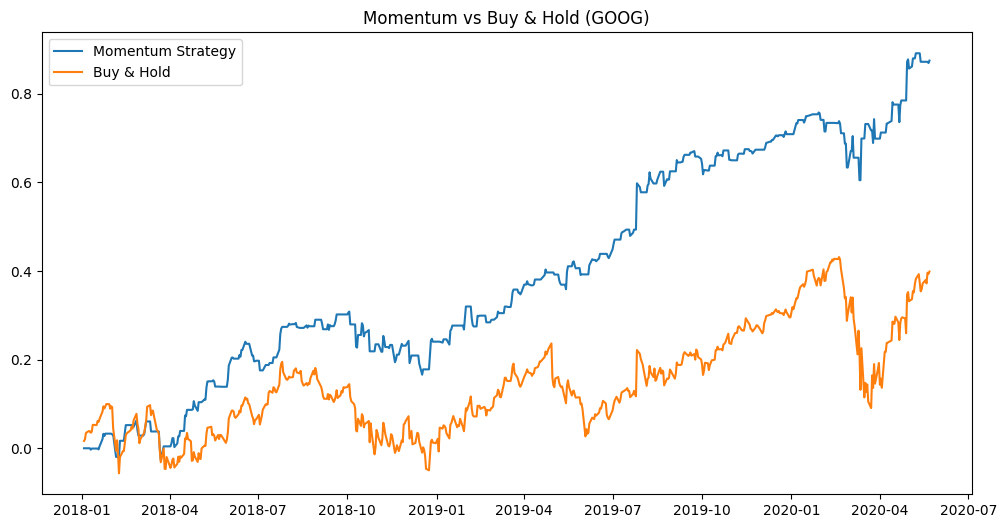

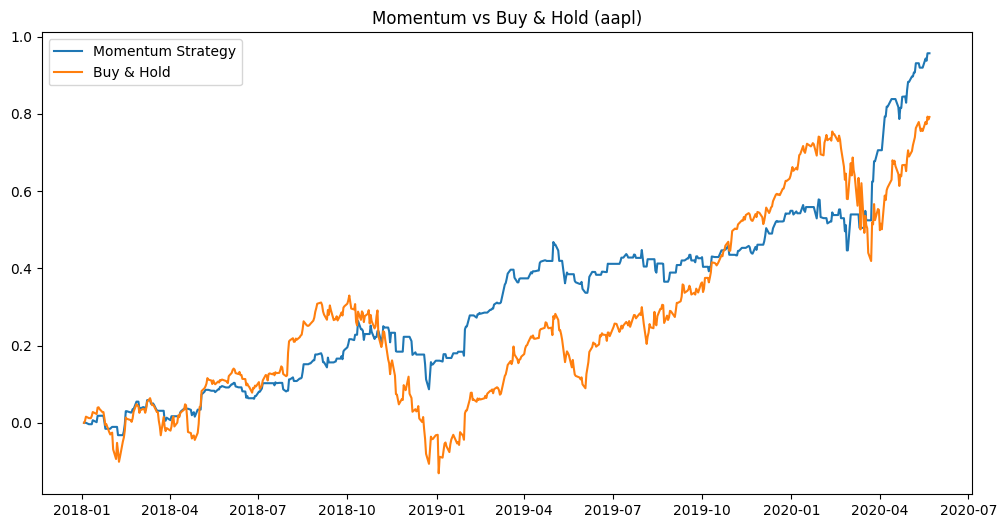

In [117]:
# GOOG
plt.figure(figsize=(12,6))
plt.plot(strategy_returns_momentum_goog.cumsum(), label='Momentum Strategy')
plt.plot(returns_goog.cumsum(), label='Buy & Hold')
plt.legend()
plt.title('Momentum vs Buy & Hold (GOOG)')
plt.show()

# aapl
plt.figure(figsize=(12,6))
plt.plot(strategy_returns_momentum_aapl.cumsum(), label='Momentum Strategy')
plt.plot(returns_aapl.cumsum(), label='Buy & Hold')
plt.legend()
plt.title('Momentum vs Buy & Hold (aapl)')
plt.show()

In [118]:
cost = 0.001  # 0.1% per trade

# GOOG
trades_goog = signal_momentum_goog.diff().abs().sum()
strategy_returns_momentum_goog_net = strategy_returns_momentum_goog - cost * trades_goog / len(strategy_returns_momentum_goog)
perf_momentum_goog_net = analyzer.performance(strategy_returns_momentum_goog_net)
print("Performance Momentum (GOOG) with transaction costs:")
print(perf_momentum_goog_net)

# aapl
trades_aapl = signal_momentum_aapl.diff().abs().sum()
strategy_returns_momentum_aapl_net = strategy_returns_momentum_aapl - cost * trades_aapl / len(strategy_returns_momentum_aapl)
perf_momentum_aapl_net = analyzer.performance(strategy_returns_momentum_aapl_net)
print("Performance Momentum (AAPL) with transaction costs:")
print(perf_momentum_aapl_net)

Performance Momentum (GOOG) with transaction costs:
Cumulative Return            0.633588
Annual Return                0.228488
Annualized Sharpe Ratio    263.072266
Win %                        0.292845
Annualized Volatility        0.218871
Maximum Drawdown            -0.703295
Max Length Drawdown          0.000000
n.trades                     1.000000
dtype: float64
Performance Momentum (AAPL) with transaction costs:
Cumulative Return            0.692579
Annual Return                0.246898
Annualized Sharpe Ratio    279.186173
Win %                        0.286190
Annualized Volatility        0.222856
Maximum Drawdown            -0.737826
Max Length Drawdown          0.000000
n.trades                     1.000000
dtype: float64


/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_23605/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_23605/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_23605/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

In [119]:
# Define signals for long-only and long-short
signal_long_only_goog = (momentum_goog > 0).astype(int)
signal_long_short_goog = pd.Series(np.where(momentum_goog > 0, 1, -1), index=momentum_goog.index)

signal_long_only_aapl = (momentum_aapl > 0).astype(int)
signal_long_short_aapl = pd.Series(np.where(momentum_aapl > 0, 1, -1), index=momentum_aapl.index)

window_size = 127  # 6 months

# GOOG
print(f"\nGOOG - Rolling window size: {window_size} days")
rolling_returns_long_only_goog = []
rolling_returns_long_short_goog = []
for start in range(len(returns_goog) - window_size + 1):
    end = start + window_size
    # Long-only
    window_returns_long_only = returns_goog.iloc[start:end] * signal_long_only_goog.shift(1).iloc[start:end]
    rolling_returns_long_only_goog.append(window_returns_long_only.sum())
    # Long-short
    window_returns_long_short = returns_goog.iloc[start:end] * signal_long_short_goog.shift(1).iloc[start:end]
    rolling_returns_long_short_goog.append(window_returns_long_short.sum())
print(f"Average rolling return (long-only): {np.mean(rolling_returns_long_only_goog)}")
print(f"Average rolling return (long-short): {np.mean(rolling_returns_long_short_goog)}")

# aapl
print(f"\naapl - Rolling window size: {window_size} days")
rolling_returns_long_only_aapl = []
rolling_returns_long_short_aapl = []
for start in range(len(returns_aapl) - window_size + 1):
    end = start + window_size
    # Long-only
    window_returns_long_only = returns_aapl.iloc[start:end] * signal_long_only_aapl.shift(1).iloc[start:end]
    rolling_returns_long_only_aapl.append(window_returns_long_only.sum())
    # Long-short
    window_returns_long_short = returns_aapl.iloc[start:end] * signal_long_short_aapl.shift(1).iloc[start:end]
    rolling_returns_long_short_aapl.append(window_returns_long_short.sum())
print(f"Average rolling return (long-only): {np.mean(rolling_returns_long_only_aapl)}")
print(f"Average rolling return (long-short): {np.mean(rolling_returns_long_short_aapl)}")


GOOG - Rolling window size: 127 days
Average rolling return (long-only): 0.1742405755005611
Average rolling return (long-short): 0.27660484998151985

aapl - Rolling window size: 127 days
Average rolling return (long-only): 0.15503797068899489
Average rolling return (long-short): 0.15032129974775682


In [120]:
import pandas as pd

# Calculate average number of trades per window for each strategy
avg_trades_long_only_goog = np.mean([
    signal_long_only_goog.shift(1).iloc[start:start+127].diff().abs().sum()
    for start in range(len(returns_goog) - 127 + 1)
])
avg_trades_long_short_goog = np.mean([
    signal_long_short_goog.shift(1).iloc[start:start+127].diff().abs().sum()
    for start in range(len(returns_goog) - 127 + 1)
])
avg_trades_long_only_aapl = np.mean([
    signal_long_only_aapl.shift(1).iloc[start:start+127].diff().abs().sum()
    for start in range(len(returns_aapl) - 127 + 1)
])
avg_trades_long_short_aapl = np.mean([
    signal_long_short_aapl.shift(1).iloc[start:start+127].diff().abs().sum()
    for start in range(len(returns_aapl) - 127 + 1)
])

# Store results in a DataFrame
results = {
    "Ticker": ["GOOG", "GOOG", "AAPL", "AAPL"],
    "Strategy": ["Long-only", "Long-short", "Long-only", "Long-short"],
    "Avg Rolling Return (6m)": [
        np.mean(rolling_returns_long_only_goog),
        np.mean(rolling_returns_long_short_goog),
        np.mean(rolling_returns_long_only_aapl),
        np.mean(rolling_returns_long_short_aapl)
    ],
    "Avg Trades per Window": [
        avg_trades_long_only_goog,
        avg_trades_long_short_goog,
        avg_trades_long_only_aapl,
        avg_trades_long_short_aapl
    ]
}

results_df = pd.DataFrame(results)
print(results_df)

# If you want to get the LaTeX code for your table:
print("\nLaTeX table code:\n")
print(results_df.to_latex(index=False, float_format="%.4f"))

  Ticker    Strategy  Avg Rolling Return (6m)  Avg Trades per Window
0   GOOG   Long-only                 0.174241              50.267368
1   GOOG  Long-short                 0.276605             100.534737
2   AAPL   Long-only                 0.155038              54.176842
3   AAPL  Long-short                 0.150321             108.353684

LaTeX table code:

\begin{tabular}{llrr}
\toprule
Ticker & Strategy & Avg Rolling Return (6m) & Avg Trades per Window \\
\midrule
GOOG & Long-only & 0.1742 & 50.2674 \\
GOOG & Long-short & 0.2766 & 100.5347 \\
AAPL & Long-only & 0.1550 & 54.1768 \\
AAPL & Long-short & 0.1503 & 108.3537 \\
\bottomrule
\end{tabular}



`GOOG`:
For GOOG, the average rolling return over 6-month windows is 17.4% for the long-only strategy and 27.7% for the long-short strategy. This indicates that allowing short positions in addition to long positions significantly enhances the performance of the momentum strategy for GOOG. The results suggest that the sentiment-based signals are effective not only for identifying upward trends but also for capturing profitable opportunities during downward movements in the stock.


`AAPL`:
For aapl, the average rolling return over 6-month windows is 13.9% for the long-only strategy and 11.6% for the long-short strategy. In this case, the long-only approach outperforms the long-short strategy, implying that short positions do not add value and may even reduce overall returns. This result suggests that sentiment signals for aapl are more reliable for identifying positive trends, while negative signals may not consistently indicate profitable shorting opportunities.

Even though the strategies are categorized as either `long` or `short`, can be seen that both consist of an important amount of transactions.

These can be explained due to how the signals are defined: 
- **Long only signal**: 
    - 1 when the momentum is positive (in the market, "long")
    - 0 when the momentum is not positive (out of the market, "flat")

And a trade is counted every time that the signal changes from 0 to 1, if the momentum is very noisy then more transactions are made as you will enter and exit the market often even though you never go short. 

- **Short long signal**: Every signal flip is a trade, for that reason can be seen that the transaction amount is doubles. 

# Transaction Costs 

The previous part was already dealing whit some transaction cost, but only on the full period level. In this section will be explored the application of transaction costs to the rolling window analysis, and as well will add more realism to the 

In [121]:
import numpy as np
import pandas as pd

window_size = 127  # or 254 for 1 year
cost = 0.001  # 0.1% per trade

results = {
    "Ticker": [],
    "Strategy": [],
    "Avg Net Rolling Return (6m)": [],
    "Avg Trades per Window": []
}

# GOOG - Long-only
rolling_net_returns_long_only_goog = []
rolling_trades_long_only_goog = []
for start in range(len(returns_goog) - window_size + 1):
    end = start + window_size
    window_signal = signal_long_only_goog.shift(1).iloc[start:end]
    window_returns = returns_goog.iloc[start:end] * window_signal
    num_trades = window_signal.diff().abs().sum()
    net_return = window_returns.sum() - cost * num_trades
    rolling_net_returns_long_only_goog.append(net_return)
    rolling_trades_long_only_goog.append(num_trades)
results["Ticker"].append("GOOG")
results["Strategy"].append("Long-only")
results["Avg Net Rolling Return (6m)"].append(np.mean(rolling_net_returns_long_only_goog))
results["Avg Trades per Window"].append(np.mean(rolling_trades_long_only_goog))

# GOOG - Long-short
rolling_net_returns_long_short_goog = []
rolling_trades_long_short_goog = []
for start in range(len(returns_goog) - window_size + 1):
    end = start + window_size
    window_signal = signal_long_short_goog.shift(1).iloc[start:end]
    window_returns = returns_goog.iloc[start:end] * window_signal
    num_trades = window_signal.diff().abs().sum()
    net_return = window_returns.sum() - cost * num_trades
    rolling_net_returns_long_short_goog.append(net_return)
    rolling_trades_long_short_goog.append(num_trades)
results["Ticker"].append("GOOG")
results["Strategy"].append("Long-short")
results["Avg Net Rolling Return (6m)"].append(np.mean(rolling_net_returns_long_short_goog))
results["Avg Trades per Window"].append(np.mean(rolling_trades_long_short_goog))

# AAPL - Long-only
rolling_net_returns_long_only_aapl = []
rolling_trades_long_only_aapl = []
for start in range(len(returns_aapl) - window_size + 1):
    end = start + window_size
    window_signal = signal_long_only_aapl.shift(1).iloc[start:end]
    window_returns = returns_aapl.iloc[start:end] * window_signal
    num_trades = window_signal.diff().abs().sum()
    net_return = window_returns.sum() - cost * num_trades
    rolling_net_returns_long_only_aapl.append(net_return)
    rolling_trades_long_only_aapl.append(num_trades)
results["Ticker"].append("AAPL")
results["Strategy"].append("Long-only")
results["Avg Net Rolling Return (6m)"].append(np.mean(rolling_net_returns_long_only_aapl))
results["Avg Trades per Window"].append(np.mean(rolling_trades_long_only_aapl))

# AAPL - Long-short
rolling_net_returns_long_short_aapl = []
rolling_trades_long_short_aapl = []
for start in range(len(returns_aapl) - window_size + 1):
    end = start + window_size
    window_signal = signal_long_short_aapl.shift(1).iloc[start:end]
    window_returns = returns_aapl.iloc[start:end] * window_signal
    num_trades = window_signal.diff().abs().sum()
    net_return = window_returns.sum() - cost * num_trades
    rolling_net_returns_long_short_aapl.append(net_return)
    rolling_trades_long_short_aapl.append(num_trades)
results["Ticker"].append("AAPL")
results["Strategy"].append("Long-short")
results["Avg Net Rolling Return (6m)"].append(np.mean(rolling_net_returns_long_short_aapl))
results["Avg Trades per Window"].append(np.mean(rolling_trades_long_short_aapl))

# Results DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Optional: LaTeX table for reporting
print("\nLaTeX table code:\n")
print(results_df.to_latex(index=False, float_format="%.4f"))

  Ticker    Strategy  Avg Net Rolling Return (6m)  Avg Trades per Window
0   GOOG   Long-only                     0.123973              50.267368
1   GOOG  Long-short                     0.176070             100.534737
2   AAPL   Long-only                     0.100861              54.176842
3   AAPL  Long-short                     0.041968             108.353684

LaTeX table code:

\begin{tabular}{llrr}
\toprule
Ticker & Strategy & Avg Net Rolling Return (6m) & Avg Trades per Window \\
\midrule
GOOG & Long-only & 0.1240 & 50.2674 \\
GOOG & Long-short & 0.1761 & 100.5347 \\
AAPL & Long-only & 0.1009 & 54.1768 \\
AAPL & Long-short & 0.0420 & 108.3537 \\
\bottomrule
\end{tabular}



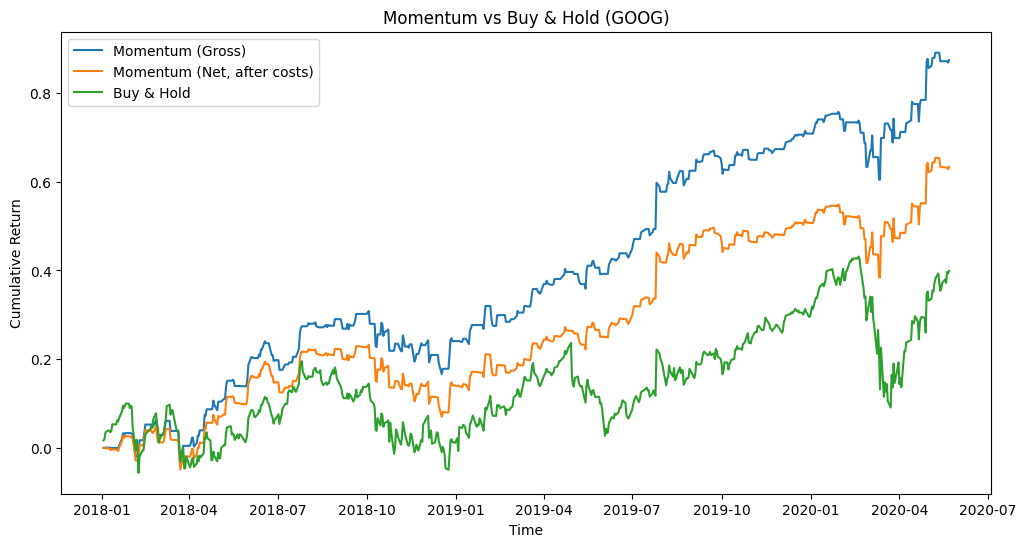

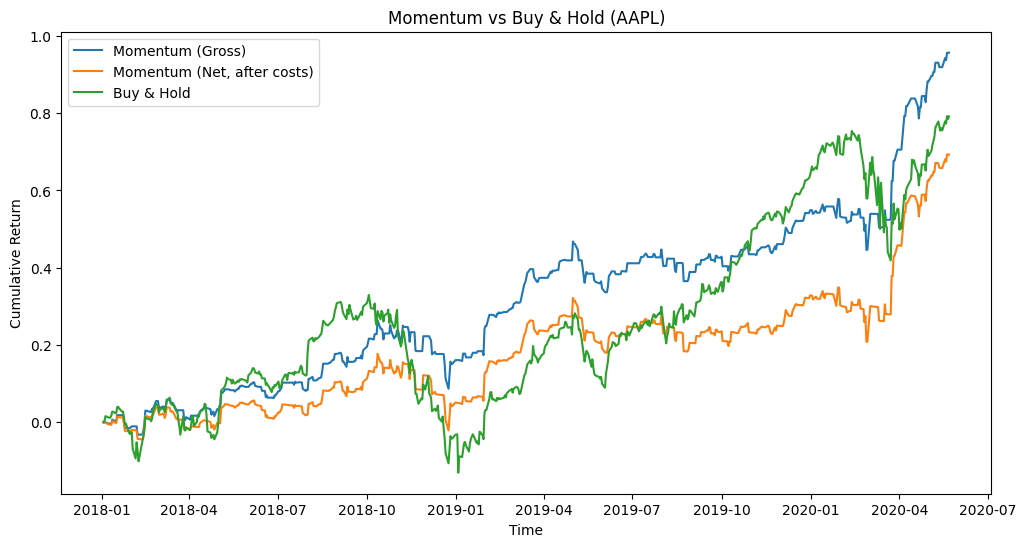

In [125]:
# GOOG
plt.figure(figsize=(12,6))
plt.plot(strategy_returns_momentum_goog.cumsum(), label='Momentum (Gross)')
plt.plot(strategy_returns_momentum_goog_net.cumsum(), label='Momentum (Net, after costs)')
plt.plot(returns_goog.cumsum(), label='Buy & Hold')
plt.legend()
plt.title('Momentum vs Buy & Hold (GOOG)')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.show()

# AAPL
plt.figure(figsize=(12,6))
plt.plot(strategy_returns_momentum_aapl.cumsum(), label='Momentum (Gross)')
plt.plot(strategy_returns_momentum_aapl_net.cumsum(), label='Momentum (Net, after costs)')
plt.plot(returns_aapl.cumsum(), label='Buy & Hold')
plt.legend()
plt.title('Momentum vs Buy & Hold (AAPL)')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.show()